In [2]:
!pip install lifelines pandas matplotlib seaborn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=1c6a37b4276e38ff40f5ecadfae1c979a068548496728230fa2964897122ed4e
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test


In [4]:
df = pd.read_excel("Data form Chlorhexidine Trial.xlsx")

df.head()


,Trial Arm,Age,Gender,Outcome of the current episode,Outcome of current episode 2,APACHE II Score,TLC Day 1,TLC Day 2,TLC Day 3,TLC Day 4,...,Ulcer Day 2,Ulcer Day 3,Ulcer Day 4,Ulcer Day 5,Ulcer Day 6,Ulcer Day 7,Ulcer Day 8,Ulcer Day 9,Ulcer Day 10,Day 1
0,Group 1,49,Male,No VAP,Discharged,11.0,11900.0,12600.0,10900.0,10400.0,...,Negative,Negative,Negative,Negative,NaN,NaN,NaN,NaN,NaN,NaN
1,Group 1,72,Male,No VAP,Discharged,17.0,16800.0,17800.0,12400.0,9300.0,...,Negative,Negative,Negative,Negative,Negative,NaN,NaN,NaN,NaN,NaN
2,Group 1,72,Male,No VAP,Death,16.0,23300.0,46600.0,39200.0,27800.0,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,NaN,NaN,NaN
3,Group 1,55,Female,No VAP,Discharged,29.0,9500.0,9500.0,9400.0,11400.0,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,NaN
4,Group 1,20,Male,No VAP,LAMA,18.0,7000.0,10900.0,11800.0,7400.0,...,Negative,Negative,Negative,Negative,Negative,NaN,NaN,NaN,NaN,NaN


In [5]:
day_cols = {d: [] for d in range(1, 11)}

for col in df.columns:
    m = re.search(r"Day (\d+)", col)
    if m:
        d = int(m.group(1))
        if d in day_cols:
            day_cols[d].append(col)

day_cols

{1: ['TLC Day 1',
  'Band Form Day 1',
  'Chest X ray Day 1',
  'CPIS Day 1',
  'ABG Day 1',
  'Cluture Day 1',
  'O S Microbial Load Day 1',
  'Ulcer Day 1',
  'Day 1'],
 2: ['TLC Day 2',
  'Band Form Day 2',
  'Chest X ray Day 2',
  'CPIS Day 2',
  'Day 2',
  'Cluture Day 2',
  'O S Microbial Load Day 2',
  'Ulcer Day 2'],
 3: ['TLC Day 3',
  'Band Form Day 3',
  'Chest X ray Day 3',
  'CPIS Day 3',
  'Day 3',
  'Cluture Day 3',
  'O S Microbial Load Day 3',
  'Ulcer Day 3'],
 4: ['TLC Day 4',
  'Band Form Day 4',
  'Chest X ray Day 4',
  'CPIS Day 4',
  'Day 4',
  'Cluture Day 4',
  'O S Microbial Load Day 4',
  'Ulcer Day 4'],
 5: ['TLC Day 5',
  'Band Form Day 5',
  'Chest X ray Day 5',
  'CPIS Day 5',
  'Day 5',
  'Cluture Day 5',
  'O S Microbial Load Day 5',
  'Ulcer Day 5'],
 6: ['TLC Day 6',
  'Band Form Day 6',
  'Chest X ray Day 6',
  'CPIS Day 6',
  'Day 6',
  'Cluture Day 6',
  'O S Microbial Load Day 6',
  'Ulcer Day 6'],
 7: ['TLC Day 7',
  'Band Form Day 7',
  'Chest X

In [6]:
def get_last_day(row):
    last = 0
    for d, cols in day_cols.items():
        if any(not pd.isna(row[c]) for c in cols):
            last = d
    return last

df["followup_days"] = df.apply(get_last_day, axis=1)

df["followup_days"].value_counts().sort_index()


,count
followup_days,
0,3
2,5
3,9
4,14
5,18
6,22
7,9
8,8
9,2


In [7]:
df = df[df["followup_days"] > 0].copy()


In [8]:
df["vap_event"] = (df["Outcome of the current episode"] == "VAP").astype(int)
df["vap_event"].value_counts()


,count
vap_event,
0,97
1,6


In [9]:
df["trial_arm"] = df["Trial Arm"].map({
    "Group 1": "CHX 0.12%",
    "Group 2": "CHX 0.20%"
})

df["trial_arm_num"] = df["Trial Arm"].map({
    "Group 1": 0,   # 0.12%
    "Group 2": 1    # 0.20%
})

df[["Trial Arm", "trial_arm", "trial_arm_num"]].head()


,Trial Arm,trial_arm,trial_arm_num
0,Group 1,CHX 0.12%,0
1,Group 1,CHX 0.12%,0
2,Group 1,CHX 0.12%,0
3,Group 1,CHX 0.12%,0
4,Group 1,CHX 0.12%,0


In [10]:
print("Number of patients:", len(df))
print("\nTrial arm counts:")
print(df["trial_arm"].value_counts())

print("\nVAP events overall:")
print(df["vap_event"].value_counts())

print("\nFollow-up days summary:")
print(df["followup_days"].describe())


Number of patients: 103

Trial arm counts:
trial_arm
CHX 0.12%    59
CHX 0.20%    44
Name: count, dtype: int64

VAP events overall:
vap_event
0    97
1     6
Name: count, dtype: int64

Follow-up days summary:
count    103.000000
mean       6.019417
std        2.322020
min        2.000000
25%        4.000000
50%        6.000000
75%        7.500000
max       10.000000
Name: followup_days, dtype: float64


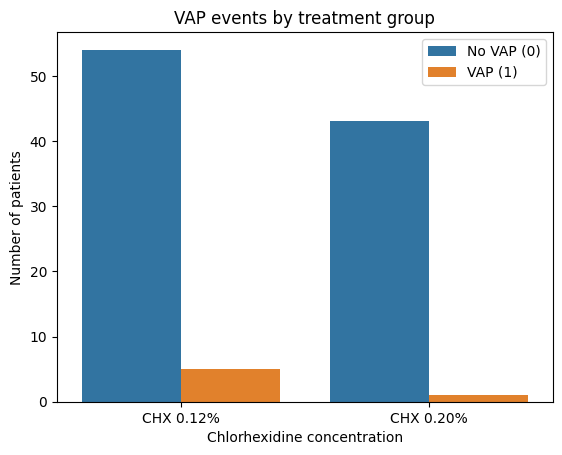

In [11]:
sns.countplot(x="trial_arm", hue="vap_event", data=df)
plt.title("VAP events by treatment group")
plt.xlabel("Chlorhexidine concentration")
plt.ylabel("Number of patients")
plt.legend(labels=["No VAP (0)", "VAP (1)"])
plt.show()


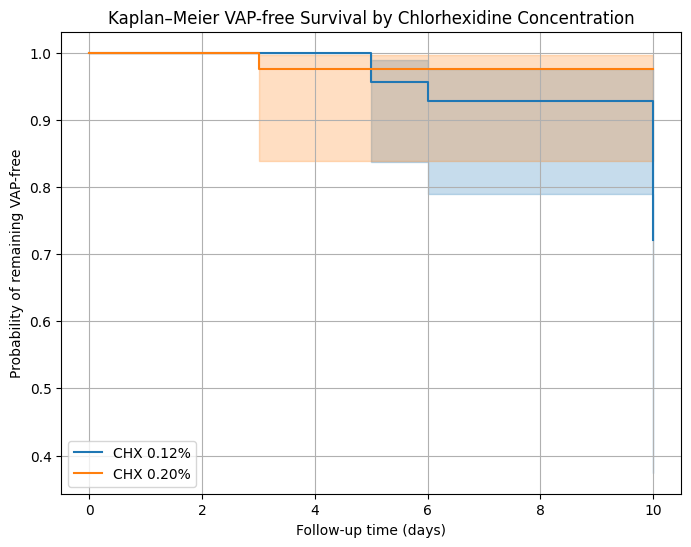

In [24]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

for label, group_data in df.groupby("trial_arm"):
    kmf.fit(
        durations=group_data["followup_days"],
        event_observed=group_data["vap_event"],
        label=label
    )
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier VAP-free Survival by Chlorhexidine Concentration")
plt.xlabel("Follow-up time (days)")
plt.ylabel("Probability of remaining VAP-free")
plt.grid(True)
plt.show()


In [13]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(df["followup_days"], event_observed=df["vap_event"])

life_table = kmf.event_table
life_table.head(15)


,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,103,103
2.0,5,0,5,0,103
3.0,9,1,8,0,98
4.0,14,0,14,0,89
5.0,18,2,16,0,75
6.0,22,1,21,0,57
7.0,9,0,9,0,35
8.0,8,0,8,0,26
9.0,2,0,2,0,18


In [14]:
kmf.fit(df["followup_days"], event_observed=df["vap_event"])
print("VAP-free probability at day 5:", kmf.predict(5))
print("VAP-free probability at day 10:", kmf.predict(10))


VAP-free probability at day 5: 0.9634013605442174
VAP-free probability at day 10: 0.8281871345029239


In [15]:
group_012 = df[df["trial_arm"] == "CHX 0.12%"]
group_020 = df[df["trial_arm"] == "CHX 0.20%"]

results = logrank_test(
    group_012["followup_days"], group_020["followup_days"],
    event_observed_A=group_012["vap_event"],
    event_observed_B=group_020["vap_event"]
)

results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.56 0.21      2.25

In [16]:
cox_df = df[["followup_days", "vap_event", "trial_arm_num", "Age", "APACHE II Score"]].dropna()

cph = CoxPHFitter()
cph.fit(cox_df, duration_col="followup_days", event_col="vap_event")

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 103 total observations, 97 right-censored observations>
             duration col = 'followup_days'
                event col = 'vap_event'
      baseline estimation = breslow
   number of observations = 103
number of events observed = 6
   partial log-likelihood = -20.12
         time fit was run = 2025-11-23 13:50:23 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
trial_arm_num   -0.80      0.45      1.14           -3.03            1.44                0.05                4.20
Age             -0.04      0.97      0.03           -0.09            0.02                0.91                1.02
APACHE II Score -0.05      0.95      0.06           -0.17            0.06                0.84                1.06

                 cmp to     z    p  -log2(p)
covariate                                   
trial_arm_num      0.00 -0.70 0.48      1.05
Age                0.00 -1.30 0.19      2.37
APACHE II Score    0.00 -0.91 0.36      1.46
---
Concordance = 0.79
Partial AIC = 46.25
log-likelihood ratio test = 5.21 on 3 df
-log2(p) of ll-ratio test = 2.67

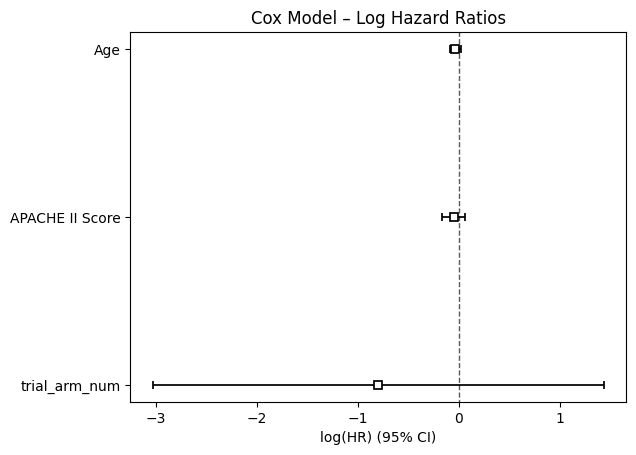

In [17]:
cph.plot()
plt.title("Cox Model – Log Hazard Ratios")
plt.show()


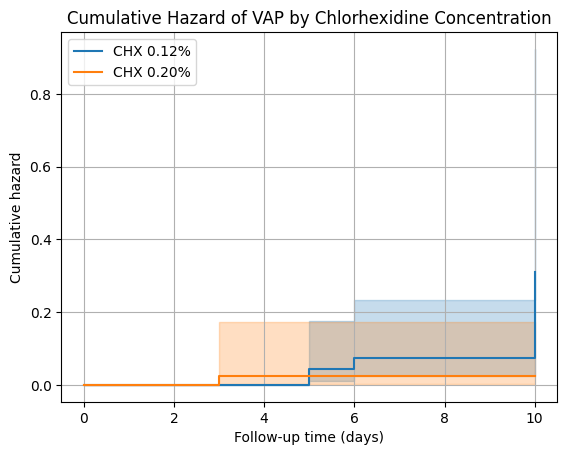

In [18]:
from lifelines import NelsonAalenFitter

naf = NelsonAalenFitter()

plt.figure()
for label, group_data in df.groupby("trial_arm"):
    naf.fit(group_data["followup_days"], event_observed=group_data["vap_event"], label=label)
    naf.plot_cumulative_hazard()

plt.title("Cumulative Hazard of VAP by Chlorhexidine Concentration")
plt.xlabel("Follow-up time (days)")
plt.ylabel("Cumulative hazard")
plt.grid(True)
plt.show()
